In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
# IF you don't have plotly installed then comment out the following lines. 
#    I am using plotly below to make interactive plots which are nice... but not
#    absolutely necessary
try:
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    pl_imported = True
except:
    pl_imported = False

At their heart, both the histogram and the CDF (Cumulative Distribution Function) are displaying similar information, but in different ways. A histogram can be thought of as an empirical estimation of the Probability Density Function (PDF) and represents the probability with areas. Technically the PDF would represent this with an "area under the curve". Histograms are bar plots... so I guess we can say they represent this with the area of a bar! The CDF represents probability with vertical distances and is cumulative.

# Histogram

First we'll look at the histogram. Below are two functions for plotting histograms. They are larger functions than you need for just a basic histogram, but that's because I like to add some annotations to my plots. The second function uses plotly to create an interactive histogram so you can hover over each bin and have the relavent info pop up.

In [ ]:
def plot_histogram(data, bins=15, hist_type='frequency', ax=None,  figsize=(5, 5),
                   estimate_pdf=True, pdf_color='purple', hist_color='green', annotate_color='blue', 
                   stat_type='summary', stat_box_loc=(0.05, 0.95), annotate_bin_idx=False,
                   show_mean=False, show_median=False, title="Normal Distribution Histogram"):
    '''
    Plot up the histogram with maybe some annotations. You can set the bin idx and it will highlight that bin
    and plot up the probability value for that bin. Uses matplotlib histogram with density=True
    
    Parameters:
        data: np.array
            the distribution you want to plot up
        bins:(int or 'auto')
            the number of bins to use when binning your data
        hist_type: str
            type of histogram to plot. `frequency`, `pdf`, `pmf`. Each type will affect the height of
            the bins
        ax:matplotlib.axes
            a matplotlib axes instance if you are creating that beforehand. Otherwise I'll create one
        figsize: tuple
            (width, height)
        estimate_pdf:bool
            Whether to plot up the estimated pdf. Assumes the distribution is a normal distribution
        hist_color: str
            any matplotlib recognized color
        pdf_color: str
            any matplotlib recognized color
        annotate_color: str
            any matplotlib recognized color
        stat_type: str
            `summary` (show summary stats), `type_summ` (show summary of type. for instance
            if plotting frequency will show N Data)
        stat_box_loc: tuple
            (x, y) coordinate in figure space not data space (0, 0) is bottom left of figure
        annotate_bin_idx: int or list of ints
            Will highlight a bin(s) and plot the probability
        
        show_mean: bool
            plot a vertical line on the mean
        show_median: bool
            plot a vertical line on the median
        distribution_name: str
            what name to put in title

    Returns:
        fig, ax
        ax        
    '''
    hist_type = hist_type.lower()
    # Setup Plot
    if not ax:
        return_fig = True
        fig, ax = plt.subplots(figsize=figsize)
    else:
        return_fig = False
        
    # PLot the histogram
    n, bins, patches = _histogram(ax, data, bins, hist_type, color=hist_color)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    
    # Plot PDF
    if estimate_pdf:
        pdf = stats.norm.pdf(bin_centers, data.mean(), data.std())
        ax.plot(bin_centers, pdf,
                linewidth=2, color=pdf_color, label='PDF')
    
    ## everything below is fluff to make this look nicer or add annotations
    # plot distribution Stats
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    if stat_type:
        if stat_type == 'summary':
            textstr = stat_string_data(data)
        elif stat_type == 'type_summ':    
            textstr = stat_string_hist(data, bins, n, hist_type=hist_type)
        else:
            raise ValueError(f'{stat_type}: Not supported')
        ax.text(stat_box_loc[0], stat_box_loc[1], textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
    
    # plot limits
    data_min, data_max = data.min(), data.max() 
    data_delta = data_max - data_min
    data_pad = data_delta * 0.03
    x_limits = (data_min - data_pad, data_max + data_pad)
    
    # Plot mean and median
    prob_max = np.max(n)
    y_limits = (0, prob_max * 1.05)
    if show_mean:
        mean = data.mean()
        ax.plot([mean, mean], [0, y_limits[1]], color='orange', ls='--', label='mean')
    if show_median:
        median = np.median(data)
        ax.plot([median, median], [0, y_limits[1]], color='brown', ls='--', label='median')
    
    # highlight example bin
    if annotate_bin_idx:
        
        ax.plot([x_limits[0], bin_centers[annotate_bin_idx]], [n[annotate_bin_idx], n[annotate_bin_idx]],
                 color=annotate_color, ls='--')
        text_loc_x = x_limits[0] + (bin_centers[annotate_bin_idx] - data_min) * 0.6
        tex_loc_y = n[annotate_bin_idx] + 0.005
        ax.text(text_loc_x, tex_loc_y, '{0:.1%}'.format(n[annotate_bin_idx]),
                fontsize=12, color=annotate_color)

        highlited_bin = ax.add_patch(patches[annotate_bin_idx])
        highlited_bin.set_edgecolor(annotate_color)
        highlited_bin.set_linewidth(3)
    
    # Format Plot
    ylabel_dict = {'frequency': 'Frequency Count', 'pdf': 'Density', 'pmf': 'Probability'}
    ax.set_xticks(bins)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    
    ax.set_ylabel(ylabel_dict[hist_type])
    ax.set_xlabel('bin ranges')
    ax.set_title(title)
    if estimate_pdf:
        ax.legend()
    
    if return_fig:
        return fig, ax
    return ax

def _histogram(ax, data, bins, hist_type, color):
    """ plot the specific type of histogram"""
     # Plot Histogram
    alpha = 0.7
    rwidth = 0.9
    if hist_type == 'frequency':
        n, bins, patches = ax.hist(x=data, bins=bins, color=color, density=False,
                                   alpha=alpha, rwidth=rwidth, label="Frequency Histogram")
    elif hist_type == 'pdf':
        n, bins, patches = ax.hist(x=data, bins=bins, color=color, density=True,
                                   alpha=alpha, rwidth=rwidth, label="Density Histogram")
    elif hist_type == 'pmf':
        weights = np.ones_like(data)/len(data)
        n, bins, patches = ax.hist(x=data, bins=bins, weights=weights, color=color, density=False,
                             alpha=alpha, rwidth=rwidth,label="Probability Histogram")
    else:
        raise ValueError(f"{hist_type}: Not supported")
    
    return n, bins, patches


def plotly_histogram(data, bins=15, hist_color='green', figsize=(500, 500), estimate_pdf=True,
                     pdf_color='purple', stat_box_loc=(0.02, 0.98), 
                     show_mean=True, show_median=True, distribution_name="Normal"):
    '''
    Create interactive histogram plots with plotly. Add options for some extra annotations. 
    np.histogram with density=True
    
    Parameters:
        data: np.array
            the distribution you want to plot up
        bins:(int or 'auto')
            the number of bins to use when binning your data
        hist_color: str
            any plotly recognized color string
        figsize: tuple
            (width, height) in pixels
        estimate_pdf:bool
            Whether to plot up the estimated pdf
        pdf_color: str
            any plotly recognized color string
        stat_box_loc: tuple
            (x, y) coordinate in figure space not data space (0, 0) is bottom left of figure
        show_mean: bool
            plot a vertical line on the mean
        show_median: bool
            plot a vertical line on the median
        distribution_name: str
            what name to put in title
    
    Returns:
        fig: go.Figure()
    '''
    # Get Stats on Distribution
    mean = data.mean()
    median = np.median(data)
    standard_deviation = data.std()
    stat_strings = '<br>'.join([f'Mean = {mean:.1f}'.format(mean), 
                                f'Median = {median:.1f}',
                                f'S.D. = {standard_deviation:.1f}']
                               )
    
    # Use numpy to create the histogram and PDF
    n, bins = np.histogram(data, bins=bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    str_bins = ['{0:.2f}'.format(x) for x in bins]
    
    if estimate_pdf:
        pdf = stats.norm.pdf(bin_centers, mean, standard_deviation)
    
    # Set up the hover template for plotly
    # hover_template = '<i>Probability: %{y:.1%}' + '<br>value: %{x:.2f}'
    hover_template = '<i>Probability: %{y:.1%}'
    
    # Create figure
    fig = go.Figure(data=[go.Bar(x=bin_centers, y=n, marker_color=hist_color,
                                 hovertemplate=hover_template, name="Histogram")],
                    layout=go.Layout(bargap=0.05))
    if estimate_pdf:
        fig.add_trace(go.Scatter(x=bin_centers, y=pdf, line={'color':pdf_color},
                                 hovertemplate=hover_template, name="PDF"))
    # Add mean and median lines
    if show_mean:
        fig.add_trace(go.Scatter(x=[mean, mean], y=[0, n.max()], 
                                 line={'color':'orange', 'dash':'dash'},
                                 mode='lines', name='Mean', hoverinfo='skip'))
    if show_median:
        fig.add_trace(go.Scatter(x=[median, median], y=[0, n.max()], 
                                 line={'color':'brown', 'dash':'dash'},
                                 mode='lines', name='Median', hoverinfo='skip'))
    # add stats annotation
    fig.add_annotation(x=stat_box_loc[0], y=stat_box_loc[1], text=stat_strings,
                       bordercolor='black', bgcolor='tan', showarrow=False,
                       xref='paper', yref='paper',
                       align='left', font=dict(size=10))
    # set up fig layout
    fig.update_layout(title={'text':f'Histogram of a {distribution_name} Distribution',
                             'x':0.5, 'xref':'paper', 'y':0.85}, 
                      width=figsize[0], height=figsize[1],
                      xaxis=dict(title='Bin Ranges', tickmode='array',
                                 tickvals=bins, ticktext=str_bins, tickangle=-90),
                      yaxis=dict(title='Probability'))
    return fig

def stat_string_data(data):
    '''
    return a plotting string with summary stats
    '''
    mean = data.mean()
    median = np.median(data)
    standard_deviation = data.std()
    stat_strings = '\n'.join([f'Mean = {mean:.1f}'.format(mean), 
                                f'Median = {median:.1f}',
                                f'S.D. = {standard_deviation:.1f}']
                               )
    return stat_strings

def stat_string_hist(data, bins, n, hist_type='frequency'):
    '''
    return a plotting string with summary stats for histogram type
    hist_type: `freqency`, `pdf`, `pmf`
    '''
    if hist_type == 'frequency':
        textstr = 'Sum of Freqency: {0} \nN Data: {1}'.format(int(n.sum()), len(data))
    elif hist_type == 'pdf':
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        sum_densities = sum(n)
        integ_d = np.trapz(n, bin_centers)
        textstr = 'Sum of Densities: {0:0.2f} \nSum of Densities Integrals: {1:0.2f}'.format(sum_densities, integ_d)
    elif hist_type == 'pmf':
        textstr = 'Sum of Probabilities: {0:0.2f}'.format(sum(n))
    else:
        raise ValueError(f"{hist_type}: Not supported")
    return textstr

**NOTE**
There are three different types of histogram. The "traditional" or frequency style, the Probability Density Function (PDF) and the Probability Mass Function (PMF). What's the difference?

Frequency
- the bar heights are equally the number of values from your distribution that fall within that bin

PDF
- the bar height equals the "area under the curve". So the integral of areas under the curve will add up to 1

PMF
- the bar height equals the probability of a value falling within the bin. So the sum of the bar heights equals  1

So here are side by side examples of the three

# Example Data
>Histograms are one commonly used graphical representation of a distribution of numbers. They are typically plotted in a bar graph style plot where the height of each bar shows the frequency of a bin and represents the probability that a number will fall within that bin. This is in essence a slice of the area under a curve. The width of the bar represents the bin size used to group the numbers (or the width of the slice). The total width of all bars shows the range of values in the distribution.

Lets first look at some numbers drawn randomly from a normal distribution (the classic bell curve distribution). In the first line of the following code I'm setting the random number seed so that you can get the exact same response I did. IF you want to change slightly every time you run this, then comment out that line

In [ ]:
np.random.seed(69569)
N=150
mu, sigma = 15, 3 # mean and standard deviation
normal_dist = np.random.normal(loc=mu, scale=sigma, size=N)

# Bimodal to show some interesting problems

mu2, sigma2 = 25, 3.2
X1 = np.random.normal(mu, sigma, N)
X2 = np.random.normal(mu2, sigma2, N)
bimodal_dist = np.concatenate([X1, X2])

Now we plot the three different types of histograms

You can also use np.histogram() and pass it to a bar plot this way

<BarContainer object of 10 artists>

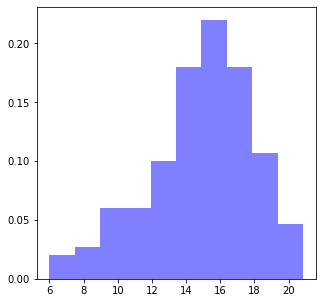

In [ ]:
heights, bins = np.histogram(normal_dist, bins=binsize)
heights = heights/sum(heights)
widths = np.diff(bins)
bin_centers = 0.5*(bins[1:] + bins[:-1])
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(bin_centers, heights, width=widths, color="blue", alpha=0.5)

Sometimes it's useful to show some annotation on the histogram such as the mean, median, and an estimated 'pdf'

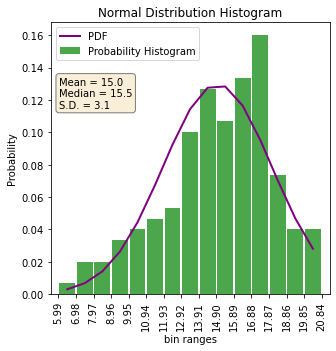

In [ ]:
binsize = 15
fig, ax = plot_histogram(normal_dist, bins=binsize, hist_type='pmf', estimate_pdf=True, stat_type='summary',
                        stat_box_loc=(0.03, 0.80))
fig.savefig('images/normal_histogram_pdf.png', dpi=150, bbox_inches='tight')

I prefer to always plot the PMF histograms by passing a set of weights (as shown above). It just makes more sense to me. Some people use the traditional frequency method and find this useful, but the frequency doesn't really mean anything without also knowing how many samples are in your distribution. If you have a count of 30 samples in a bin and your sample size is 50 then that means something totally different than if you have a sample size of 10,000. I am often thinking in “probabilities” so I prefer histograms that convert the frequency to a probability, I prefer the "PMF" method because that tells me the probability that a value will fall within a bin. Unfortunately there aren't necessarily straightforward ways to plot this. I originally thought using the 'Density' option in numpy/matplotlib/plotly was converting it over to a probability value, but that turns out to be the "area under the curve" which is different. Many stackoverflow posts later and very far down the rabbit hole I finally more or less figured out the differences.

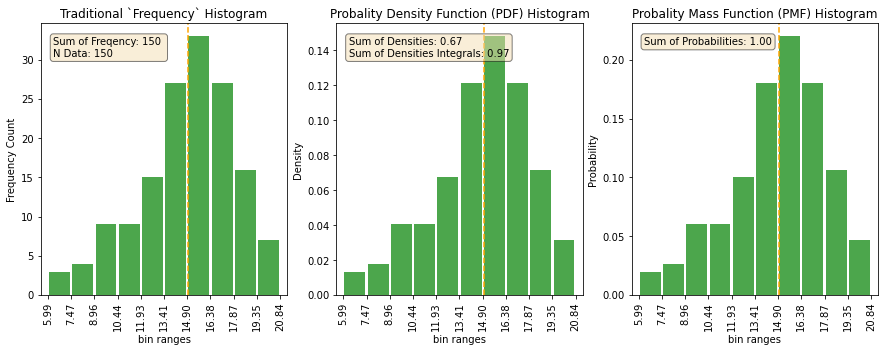

In [ ]:
binsize = 10
data = normal_dist
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
plot_histogram(data, bins=binsize, ax=ax[0], hist_type='frequency', stat_type='type_summ',
               title='Traditional `Frequency` Histogram', estimate_pdf=False, show_mean=True)
plot_histogram(data, bins=binsize, ax=ax[1], hist_type='pdf', stat_type='type_summ',
               title="Probality Density Function (PDF) Histogram", estimate_pdf=False, show_mean=True)
plot_histogram(data, bins=binsize, ax=ax[2], hist_type='pmf', stat_type='type_summ',
               title="Probality Mass Function (PMF) Histogram", estimate_pdf=False, show_mean=True)
fig.savefig('images/normal_histogram_types.png', dpi=150, bbox_inches='tight')

Ok so you probably already knew what a histogram was, and you might already know how to read a histogram, but to make sure we are on the same page lets look at what the histogram shows us. We'll take the same normal distribution and plot it's histogram, but this time in an interactive plot so you can look at some of the values yourself. If you don't have plotly, then there are some static plots further down.

In [ ]:
if pl_imported:
    fig = plotly_histogram(normal_dist)
    fig.show()
    fig.write_html('images/2020-04-normal_histogram_pdf.html')

First there are a some general pieces of information we can see from the plot without plotting any annotation. These are the range of values, probability of a value within a bin, the general shape of the distribution, the skewness of the distribution, and possible outliers. So lets look at those with the above plot:

| Range of values | 5.99 to 20.84 |

| Probability of value in 4th bin | ~3.4% |

| Shape of the distribution | Typical normal "bell curve" |

| Skewness | Maybe slightly to the right |

| Outliers | maybe some at the start |

In the above table, we did say there wasn't much skewness. How do we know that? Well some of it is based on our own loosy-goosy feeling of what the shape looks like. The other way we can get a quick sense is to also plot the mean and median lines and see if they "look" close together. Which brings up another interesting point. You can't really tell what the mean or median of your distribution is without plotting them. It's a non-trivial probablem to add up in our heads the probabilities of all the different bins and figure out which bin lies in the middle. Here it might look easy because we are dealing with a normal distribution. In Part 2, we'll look at a bunch of different distributions, such as the log normal distribution, and you can see how hard it is to actually tell intuitively where your median value is.

*Side Note: You can calculate a Skewness value for a less `loosy-goosy` feeling*

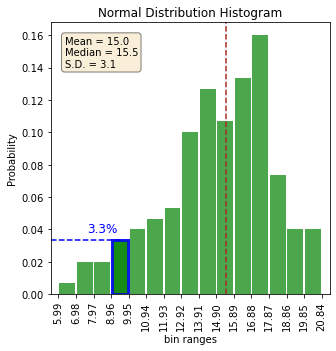

In [ ]:
# Similar plot as above but not as fancy
fig, ax = plot_histogram(normal_dist, estimate_pdf=False, show_median=True, hist_type='pmf',
                         show_mean=False, annotate_bin_idx=3)
fig.savefig('images/normal_histogram_annotated.png', dpi=150, bbox_inches='tight')

# CDF

Now we'll look at the cumulative distribution function (aka. CDF) which is another graphical representation of the distribution of numbers (discrete, or continuous). Below are a couple of usefull functions. First is a quick function to create the x, y values for the cdf plot and the second two are fancy plots functions for the cdf. Comment out the plotly one if you aren't using plotly

In [ ]:
def ecdf(data):
    '''
    Take an array of your distribution values and return
    an emperical cdf
    
    Paramaters:
        data:np.array or list
        
    Returns:
        sorted_array, yidx_array
    '''
    if isinstance(data, list): data = np.array(data)
    
    # sort unique data
    x_values = np.sort(data)
    # calculate cumulative probability
    d_size = len(x_values)
    y_values = np.arange(1, d_size + 1) / d_size 

    return x_values, y_values

def plot_ecdf(data, cdf_color='green', ax=None, figsize=(5, 5), stat_box_loc=(0.03, 0.75),
              percentiles_to_annotate=0.5, annotate_colors='#c51b8a',
              distribution_name='Normal', return_fig=False):
    '''
    Given a distribution plot the cdf and stats for the cdf. You can also pass it some percentiles and it will
    annotate those with lines and values on the plot
    
    Parameters:
        data: np.array
            the distribution you want to plot up
        cdf_color: str
            any matplotlib recognized color
        ax:matplotlib.axes
            a matplotlib axes instance if you are creating that beforehand. Otherwise I'll create one
        figsize: tuple
            (width, height)
        stat_box_loc: tuple
            (x, y) coordinate in figure space not data space (0, 0) is bottom left of figure
        percentiles_to_annotate: (float, [floats] or False)
            if you want to plot some lines and annotations for specific but in the decimal
            form here. i.e. [0.2, 0.8] for the P20 and the P80
        annotate_color: str
            any matplotlib recognized color. Must be same number of colors as percentiles_to_annotate
            unless False was passed to the percentiles
        distribution_name: str
            what name to put in title
        return_fig: bool
            to return fig or not. will always return at least ax
            
    Returns:
        fig, ax
        ax
    '''
    x, y = ecdf(data)
    median = np.median(data)
    standard_deviation = data.std()
    textstr = '\n'.join((f'median={median:.1f}',
                     rf'$\sigma={standard_deviation:.1f}$')
                       )
    data_min = data.min()
    data_max = data.max()
    data_delta = data_max - data_min
    data_pad = data_delta * 0.03
    x_limits = (data_min- data_pad, data_max + data_pad)
    if not ax:
        return_fig = True
        fig, ax = plt.subplots(figsize=figsize)
    else:
        return_fig = False
    ax.plot(x, y, color=cdf_color, label='CDF')
    
    # plot distribution Stats
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(stat_box_loc[0], stat_box_loc[1], textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    # Annotate the Percentiles if Passed
    if percentiles_to_annotate:
        if isinstance(percentiles_to_annotate, float):
            percentiles_to_annotate =[ percentiles_to_annotate]
        if isinstance(annotate_colors, str):
            annotate_colors = [annotate_colors]
        for idx, perc in enumerate(percentiles_to_annotate):
            idx_p = np.where(y == perc)[0][0] # Could change this to something fancy values don't line up
            perc_value = x[idx_p]
            perc_label = "{0}".format(perc * 100)
            ax.plot([perc_value, perc_value], [0, perc], color=annotate_colors[idx],
                    ls='--', label=f'P{perc_label}')
            ax.plot([x_limits[0], perc_value], [perc , perc],
                    color=annotate_colors[idx], ls='--')
            # Plot Percentile Text
            text_loc_horz = x_limits[0] + (perc_value - data_min) * 0.6
            text_loc_vert = perc + 0.01
            ax.text(text_loc_horz, text_loc_vert, '{0} %'.format(perc_label),
                    fontsize=12, color=annotate_colors[idx])
            # Plot Value Text
            text_loc_horz = perc_value + 0.1
            text_loc_vert = perc * 0.7
            ax.text(text_loc_horz, text_loc_vert, f'{perc_value:.1f}',
                    fontsize=12, color=annotate_colors[idx])
        # Format Plot
        ax.set_xlim(x_limits)
        ax.set_ylim(0, 1)
        #ax.tick_params(axis='x', labelrotation=90)
        ax.set_ylabel('probability (at or below value)')
        ax.set_xlabel('Value')
        ax.set_title(f'CDF of a {distribution_name} Distribution')
        ax.grid()
        ax.legend(loc=0)
    if return_fig:
        return fig, ax
    return ax

def plotly_ecdf(data, cdf_color='green', figsize=(500, 500), stat_box_loc=(0.02, 0.98),  
                distribution_name='Normal', plot_p50_line=True):
    '''
    Given a distribution plot the cdf and stats for the cdf. Creates an interactive plot using plotly
    
    Parameters:
        data: np.array
            the distribution you want to plot up
        cdf_color: str
            any matplotlib recognized color
        ax:matplotlib.axes
            a matplotlib axes instance if you are creating that beforehand. Otherwise I'll create one
        figsize: tuple
            (width, height)
        stat_box_loc: tuple
            (x, y) coordinate in figure space not data space (0, 0) is bottom left of figure\
        distribution_name: str
            what name to put in title
        plot_p50_line: bool
            Can plot a dashed line hightlighting the median (50th percentile)
            
    Returns:
        fig: go.Figure()
    '''
    x, y = ecdf(data)
    median = np.median(data)
    standard_deviation = data.std()
    data_min = data.min()
    stat_strings = '<br>'.join([f'Median = {median:.1f}',
                                f'S.D. = {standard_deviation:.1f}']
                               )
    hover_template = '<i>Probability: %{y:.1%}' + '<br>value: %{x:.2f}'
    
    # Create figure
    fig = go.Figure(go.Scatter(x=x, y=y, line={'color':cdf_color},
                               hovertemplate=hover_template, name="CDF"))
    # median lines
    if plot_p50_line:
        fig.add_trace(go.Scatter(x=[median, median, data_min], y=[0, 0.5, 0.5], 
                                 line={'color':'brown', 'dash':'dash'},
                                 mode='lines', name='Median', hoverinfo='skip'))
        
    # add stats annotation
    fig.add_annotation(x=stat_box_loc[0], y=stat_box_loc[1], text=stat_strings,
                       bordercolor='black', bgcolor='tan', showarrow=False,
                       xref='paper', yref='paper',
                       align='left', font=dict(size=10))
    # set up fig layout
    fig.update_layout(title={'text':f'CDF of a {distribution_name} Distribution',
                             'x':0.5, 'xref':'paper', 'y':0.85}, 
                      width=figsize[0], height=figsize[1],
                      xaxis=dict(title='Value'),
                      yaxis=dict(title='Probability', tick0=0, rangemode='nonnegative'))
    return fig

On the CDF plot, the y-axis represents the cumulative probability, aka the percentile of your distribution. The x-axis is the values in your distribution (ordered from least to greatest). The line is using vertical distances to show the probabilities. Here's an example of the same normal distribution.

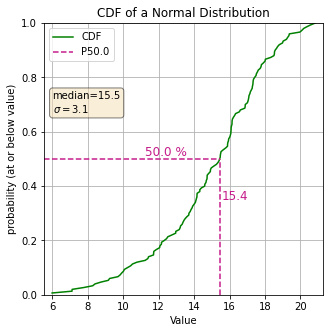

In [ ]:
fig, ax = plot_ecdf(normal_dist)
fig.savefig('images/normal_cdf.png', dpi=150, bbox_inches='tight')

The CDF also works quite well for categorical distributions. Just be mindful of how the categories are related. It works well with ordinal but not nominal (i.e. there is no meaning to the order of the categories. for example `provinces`). Here's an example of the same normal distribution converted into a categorical distribution by converting all values to integers:

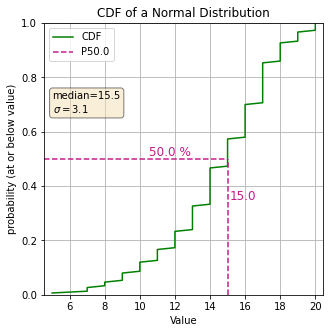

In [ ]:
norm_int_dist = normal_dist.astype(int)
fig, ax = plot_ecdf(norm_int_dist)
fig.savefig('images/normal_int_cdf.png', dpi=150, bbox_inches='tight')

Now that we know what a CDF is, lets start looking at what sort of information one can glean from this graph. This time we'll plot up the CDF in an interactive plot. So go ahead and play around with it some! Again, if you aren't using plotly then continue on down and there are some static plots as well

In [ ]:
fig = plotly_ecdf(normal_dist)
fig.show()
fig.write_html('images/2020-04-normal_cdf.html')

What are the general pieces of information we can see? The range of values, Percentiles (i.e. P20 is where 20% of the values are less than or equal to that value), Your median (because the median is the P50), anything related to the percentiles (i.e. what values are between the P20 and the P80, or what values lie within +/- 20% of the median). So looking at the above cdf to find the percentile we find the decimal percentile value on the Y axis (P20 = 0.2) drew a line horizontally over to our cdf line and then go straight down, that's the percentile of our distribution. So let's look at some of those values for the above plot:

| P20 | 11.6 |

| Median (P50) | 14.4 |

| Values between P20 - P80 | 11.6 to 17.2 |

| Probability of values between 11.6 and 17.2 | 80% - 20% = 60% |

What about the slope of the line? The slope of the line along the CDF also gives us some basic information. This in affect tells us how spread out values are. A steeper slope means that the there is less spread and a shallower slope gives shows a greater relative spread in your data. So if we have a relatively shallow slope at the top or bottom that could be an indication of possible outliers. Also if there is a relatively shallow slope somewhere in the middle of the distribution, that could be a sign of a bimodal distribution.

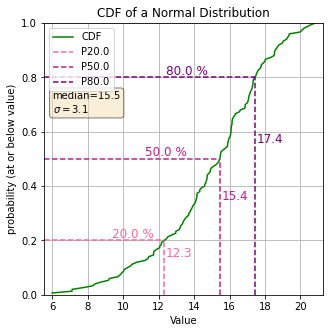

In [ ]:
perc_color_list = ['#f768a1','#c51b8a','#7a0177']
perc_list = [0.2, 0.5, 0.8]
fig, ax = plot_ecdf(normal_dist, percentiles_to_annotate=perc_list, annotate_colors=perc_color_list)
fig.savefig('images/normal_cdf_annotated.png', dpi=150, bbox_inches='tight')

# How Bin size can change the looks
> If you are only looking at the plots...then the bin size can affect how you read or interpret your data.

Lets look at some examples

In [ ]:
# Same example data as above
np.random.seed(69569)
N=150
mu, sigma = 15, 2 # mean and standard deviation
normal_dist = np.random.normal(loc=mu, scale=sigma, size=N)

# Bimodal to show some interesting problems

mu2, sigma2 = 20, 1
X1 = np.random.normal(mu, sigma, N)
X2 = np.random.normal(mu2, sigma2, N)
bimodal_dist = np.concatenate([X1, X2])

In [ ]:
np.median(bimodal_dist)

18.321247966139445

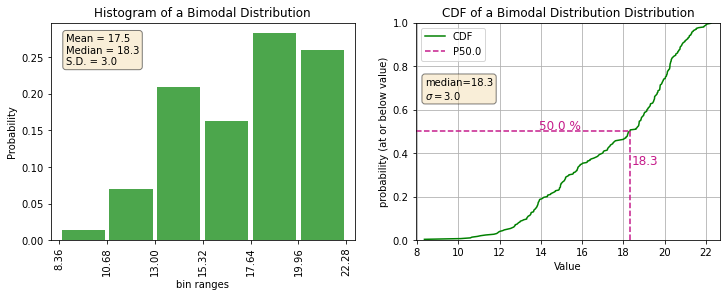

In [ ]:
data = bimodal_dist
bins = 6
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0] = plot_histogram(data, ax=ax[0], bins=bins, hist_type='pmf',
                       estimate_pdf=False, title='Histogram of a Bimodal Distribution')
ax[1] = plot_ecdf(data, ax=ax[1], distribution_name='Bimodal Distribution', return_fig=False)

> Histogram Observation: We might have an outlier.... Distribution could be a skewed normal distribution? 

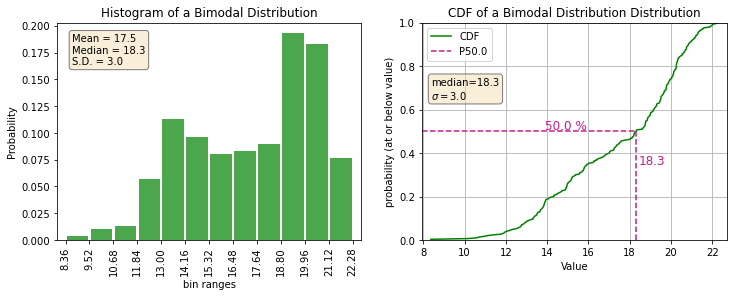

In [ ]:
data = bimodal_dist
bins = 12
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0] = plot_histogram(data, ax=ax[0], bins=bins, hist_type='pmf',
                       estimate_pdf=False, title='Histogram of a Bimodal Distribution')
ax[1] = plot_ecdf(data, ax=ax[1], distribution_name='Bimodal Distribution', return_fig=False)

>  Histogram Observation: We probably have some outliers, distribution almostlooks moslty uniform with a spike?

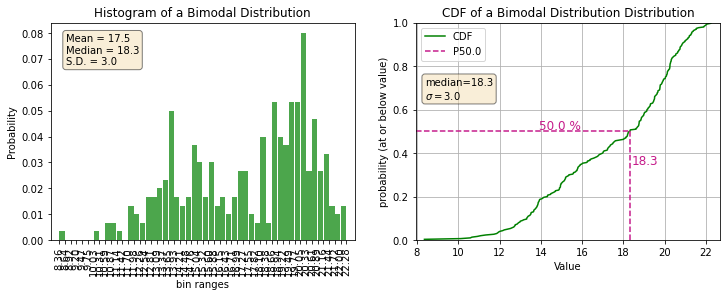

In [ ]:
data = bimodal_dist
bins = 50
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0] = plot_histogram(data, ax=ax[0], bins=bins, hist_type='pmf',
                       estimate_pdf=False, title='Histogram of a Bimodal Distribution')
ax[1] = plot_ecdf(data, ax=ax[1], distribution_name='Bimodal Distribution', return_fig=False)

> Histogram Observation:  Definitely have some outliers.. distribution is looking more like a by modal distribution

The other thing to note above. Although the bins can change how the histogram looks, the CDF doesn't use bins so that doesn't change any of them. You can also definitely pick out the left side outliers in the CDF. The bimodal aspect isn't super clear but it is somewhat apparent

## Plot for a bunch of Distributions

It can be interesting to compare how different distributions look in a Histograms and a CDF. This is one area where the Histogram is much better than the CDF. It can be hard to tell the difference distribution types on a cdf. However later we'll look at comparing multiple distributions to each other, in that case the CDF shines.

In [ ]:
dist = dict()
dist_size = 500

dist['Lognormal'] = {"data": np.random.lognormal(0, 1, size=dist_size), "bin":30}
dist['Chisquare'] = {"data": np.random.chisquare(2, size=dist_size), "bin":30}
dist['Beta'] = {"data": np.random.beta(1, 4, size=dist_size), "bin":30}
dist['Gamma'] = {"data": np.random.gamma(2, 2, size=dist_size), "bin":20}

dist['Triangular'] = {"data": np.random.triangular(-3, 0, 8, size=dist_size), "bin":'auto'}
dist['Normal'] = {"data": np.random.normal(size=dist_size), "bin":'auto'}

dist['Uniform'] = {"data": np.random.uniform(size=dist_size), "bin":'auto'}
dist['Binomial'] = {"data": np.random.binomial(10, 0.5, size=dist_size), "bin":'auto'}
dist['Poisson'] = {"data": np.random.poisson(size=dist_size), "bin":'auto'}

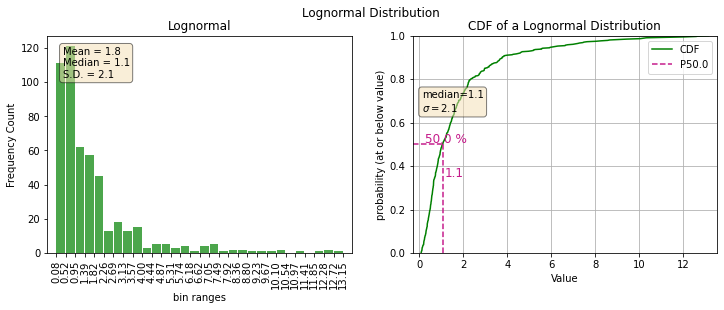

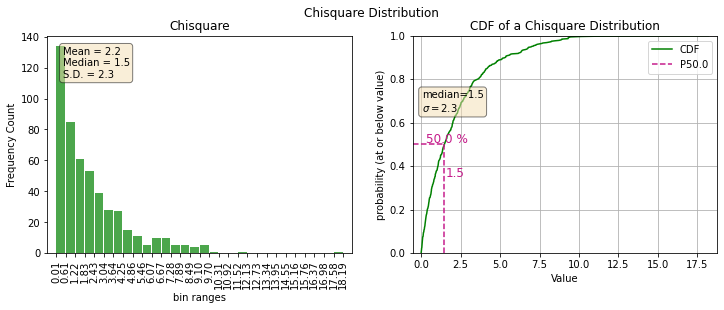

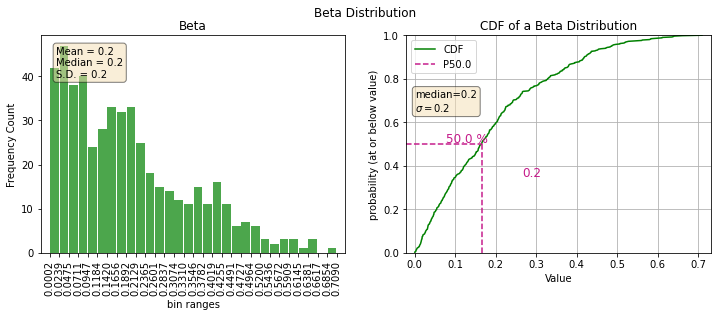

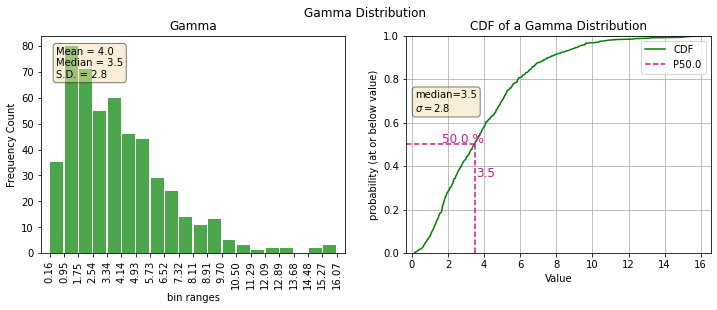

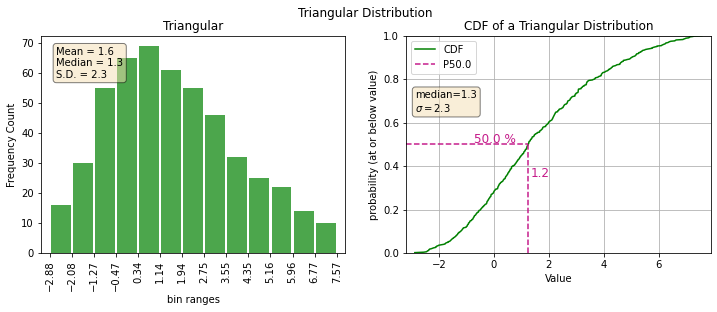

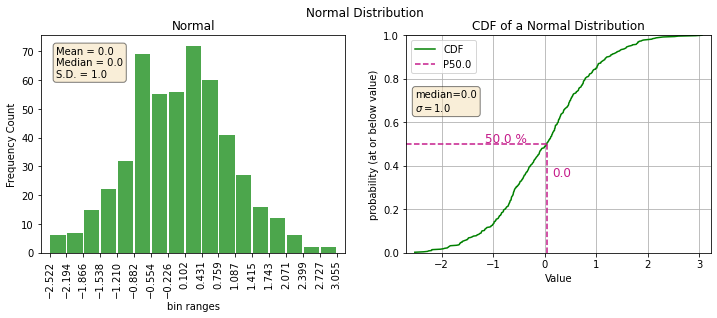

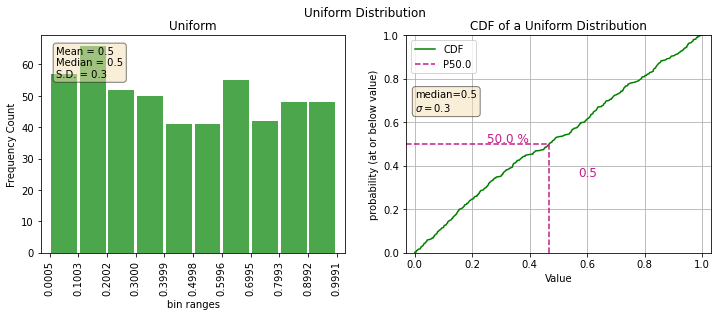

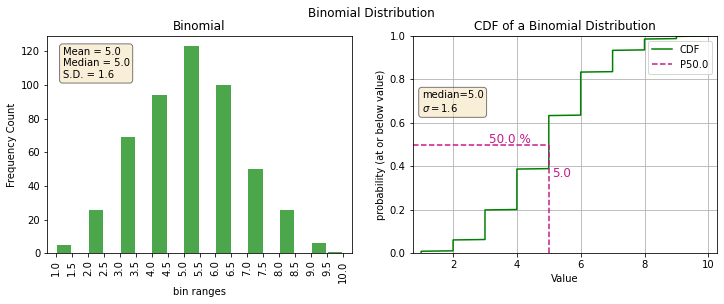

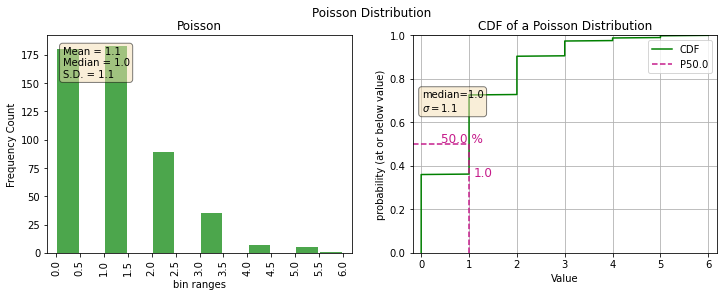

In [ ]:
for d_type in dist.keys():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    ax[0] = plot_histogram(dist[d_type]['data'], ax=ax[0], bins=dist[d_type]['bin'],
                           estimate_pdf=False, title=d_type)
    ax[1] = plot_ecdf(dist[d_type]['data'], ax=ax[1], distribution_name=d_type, return_fig=False)
    fig.suptitle(f'{d_type} Distribution')
    fig.savefig(f'images/compare_hist_cdf_{d_type}.png', dpi=150, bbox_inches='tight')